In [19]:
import nltk
nltk.download('punkt')
import pyphen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from numpy import random

def average_sentence_length(preprocessed_text):
    ''' Average length of a sentence. All characters and symbols are included.'''
    return np.mean([len(sentence) for sentence in preprocessed_text])

def average_syllable_word(preprocessed_text):
    '''Average length of a sentence. SYM are excluded and not counted'''
    pyphen.language_fallback('de_DE_variant1')
    dic = pyphen.Pyphen(lang='de_DE')
    counts = []
    for sentence in preprocessed_text:
        for word in sentence:
            if word[1]!="SYM":
                counts.append(syllable_count(word[0], dic))
    
    return np.mean(counts)

def syllable_count(string, dic):
    '''The number of syllables of a string is returned'''
    return len(dic.inserted(string).split("-"))

def Flesch_Reading_Ease_Score(preprocessed_text):
    ''' On a given text the score will produce a value between 1 and 100 where the higher
    the value the easier the text would be. Documents scoring 30 are very difficult to
    read while those scoring 70 should be easy to read.'''
    asl = average_sentence_length(preprocessed_text)
    asw = average_syllable_word(preprocessed_text)
    
    return 206.835 - (1.015 * asl) - (84.6 * asw)

def Flesch_Kincaid_readability(preprocessed_text):
    '''The Flesch-Kincaid readability formula (2.2) simplifies the Flesch score to produce a “grade
    level” which is easily interpretable (i.e., a text with a grade level of eight according to the formula
    could be thought appropriate for an eighth grader).'''
    asl = average_sentence_length(preprocessed_text)
    asw = average_syllable_word(preprocessed_text)
    
    return (0.4 * asl) + (12 * asw) - 15

def percentag_hard_words(preprocessed_text):
    pyphen.language_fallback('de_DE_variant1')
    dic = pyphen.Pyphen(lang='de_DE')
    count_hard_words=0
    length=0
    for sentence in preprocessed_text:
        for word in sentence:
            if word[1]!="SYM":
                length+=1
                if syllable_count(word[0], dic)>=3:
                    count_hard_words+=1
            
    return count_hard_words/length
                
def fog(preprocessed_text):
    hw = percentag_hard_words(preprocessed_text)
    asl = average_sentence_length(preprocessed_text)
                
    return 0.4 * (hw + asl)

def polysyllable_count(preprocessed_text):
    '''the number of words with 3 or more syllables in 30 sentences
    which shall be picked from the beginning, middle, and end of the document.'''
    pyphen.language_fallback('de_DE_variant1')
    dic = pyphen.Pyphen(lang='de_DE')
    part_len = int(len(preprocessed_text)/3)
    
    if part_len > 10:
        beginning_sentences = preprocessed_text[:part_len]
        middle_sentences = preprocessed_text[part_len:-part_len]
        end_sentences = preprocessed_text[-part_len:]
        picked_sentences = random.choice(beginning_sentences, 10) + random.choice(middle_sentences, 10) + random.choice(end_sentences, 10)
    else:
        picked_sentences = preprocessed_text
    
    polysyllable_count = 0
    for sentence in picked_sentences:
        for word in sentence:
            if syllable_count(word[0], dic)>=3:
                polysyllable_count+=1
    
    return polysyllable_count

def smog(preprocessed_text):
    psc = polysyllable_count(preprocessed_text)
    return 3 + np.sqrt(psc)

[nltk_data] Downloading package punkt to /home/soeren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
df=pd.read_csv(r"preprocessed_text_df.csv", sep="|", lineterminator='\n')
import ast
display(df.head())
df["preprocessedText"]  = [ast.literal_eval(text) for text in df["RFTagger"]]
df["average_sentence_length"] = [average_sentence_length(text) for text in df["preprocessedText"]]
df["average_syllable_word"] = [average_syllable_word(text) for text in df["preprocessedText"]]
df["Flesch_Reading_Ease_Score"] = [Flesch_Reading_Ease_Score(text) for text in df["preprocessedText"]]
df["Flesch_Kincaid_readability"] = [Flesch_Kincaid_readability(text) for text in df["preprocessedText"]]
df["percentag_hard_words"] = [percentag_hard_words(text) for text in df["preprocessedText"]]
df["fog"] = [fog(text) for text in df["preprocessedText"]]
df["polysyllable_count"] = [polysyllable_count(text) for text in df["preprocessedText"]]
df["smog"] = [smog(text) for text in df["preprocessedText"]]
df.head()
filename = "basic_features_df.csv"
df.to_csv(filename)

,Level,Title,Text,Source,Type,cleanedText,RFTagger,parsedText
0,A1,Meine Familie,Zu meiner Familie gehören vier Personen. Die M...,https://german.net/reading/familie/,Reading,Zu meiner Familie gehören vier Personen. Die M...,"[[['Zu', 'APPR', 'Dat'], ['meiner', 'PRO', 'Po...",['(ROOT (S (PP (APPR Zu) (PPOSAT meiner) (NN F...
1,A1,Maria und ihre Familie,Mein Name ist Maria. Ich bin 30 Jahre alt. Zu ...,https://german.net/reading/marias-familie/,Reading,Mein Name ist Maria. Ich bin 30 Jahre alt. Zu ...,"[[['Mein', 'PRO', 'Poss', 'Attr', '-', 'Nom', ...",['(ROOT (S (NP (PPOSAT Mein) (NN Name)) (VAFIN...
2,A1,Ich bin Tom,Hallo! Ich bin Tom Maier. Ich bin 13 Jahre alt...,https://german.net/reading/tom/,Reading,Hallo! Ich bin Tom Maier. Ich bin 13 Jahre alt...,"[[['Hallo', 'ITJ'], ['!', 'SYM', 'Pun', 'Sent'...","['(ROOT (NUR (ITJ Hallo) ($. !)))', '(ROOT (S ..."
3,A1,Freundinnen,Ricarda ist 21 Jahre alt und wohnt in Lübeck. ...,https://german.net/reading/freundinnen/,Reading,Ricarda ist 21 Jahre alt und wohnt in Lübeck. ...,"[[['Ricarda', 'N', 'Name', 'Nom', 'Sg', 'Fem']...",['(ROOT (CS (S (NE Ricarda) (VAFIN ist) (AP (N...
4,A1,Einkaufen im Supermarkt,Frau Meier geht heute in den Supermarkt. Ihr M...,https://german.net/reading/einkaufen/,Reading,Frau Meier geht heute in den Supermarkt. Ihr M...,"[[['Frau', 'N', 'Reg', 'Nom', 'Sg', 'Fem'], ['...",['(ROOT (S (NP (NN Frau) (NE Meier)) (VVFIN ge...


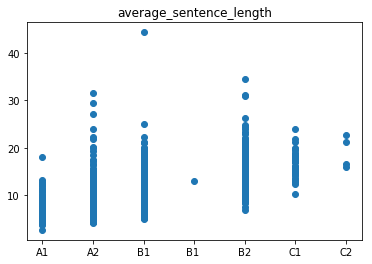

array(['A1', 'A2', 'B1', 'B2', 'B1 ', 'C1', 'C2'], dtype=object)

In [22]:
plt.scatter(df["Level"], df["average_sentence_length"])
plt.title("average_sentence_length")
plt.show()

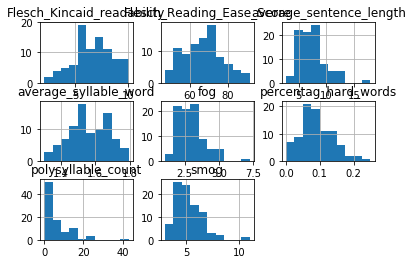

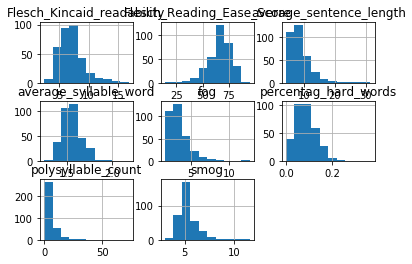

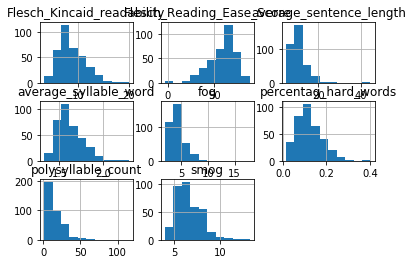

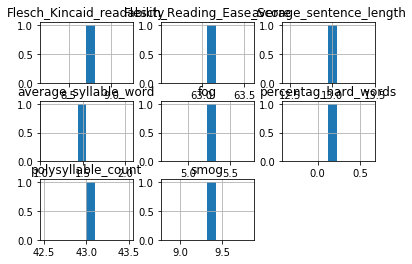

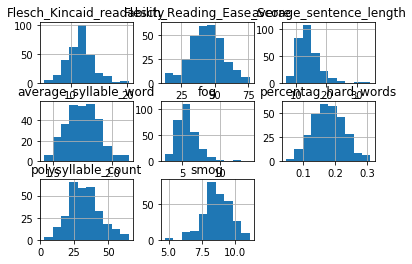

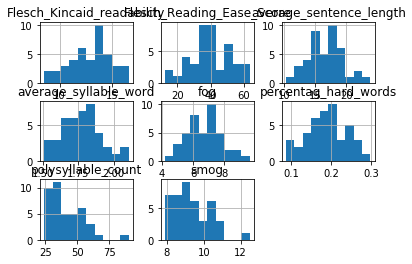

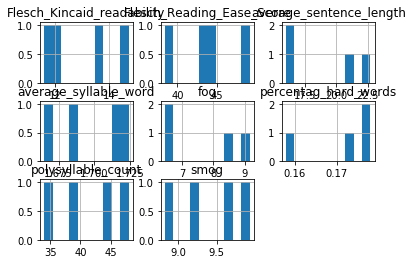

In [24]:
df.groupby("Level").hist()
plt.show()

In [29]:
df.groupby('Level')

AttributeError: 'DataFrameGroupBy' object has no attribute 'plas'